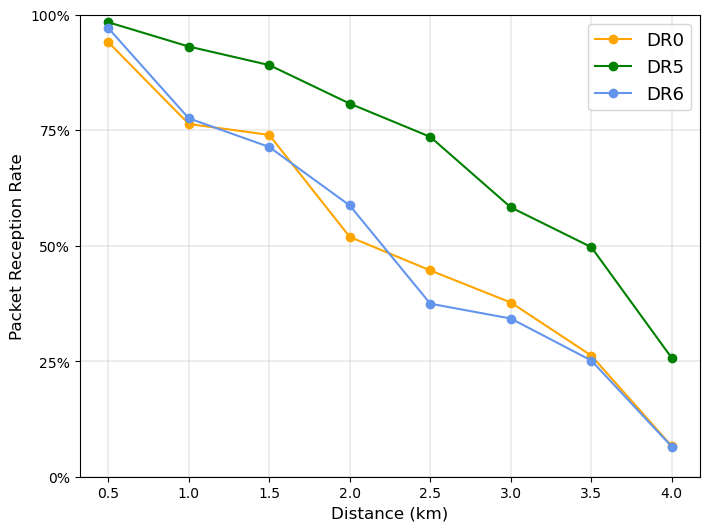

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

# Connect to the database and load data
db_file = './database.db'
conn = sqlite3.connect(db_file)
data = pd.read_sql('SELECT * FROM data', conn)

# Create a binary label for signal reception
data['signal_received'] = ~data['rssic'].isna()

# Define distance bins (0.5 km intervals)
bins = np.arange(0, 4.5, 0.5)
data['distance_bin'] = pd.cut(data['gw_distance'], bins)

# Data rates to analyze
data_rates = ['0', '5', '6']
colors = {'0': 'orange', '5': 'green', '6': 'cornflowerblue'}

# Prepare the plot
plt.figure(figsize=(8, 6))

for dr in data_rates:
    df_dr = data[data['dr'] == dr]
    
    # Count packets received and total packets per distance bin
    bin_counts = df_dr.groupby(['distance_bin', 'signal_received'], observed=False).size().unstack(fill_value=0)
    bin_counts = bin_counts.reindex(pd.IntervalIndex(data['distance_bin'].cat.categories), fill_value=0)
    total_packets = bin_counts.sum(axis=1)
    reception_rate = (bin_counts[True] / total_packets).fillna(0)
    
    # Extract distances and reception rates
    distances = [interval.right for interval in reception_rate.index]
    rates = reception_rate.values
    
    # Plot the data
    plt.plot(distances, rates, 'o-', color=colors[dr], label=f'DR{dr}')

# Customize the plot
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Packet Reception Rate', fontsize=12)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.25), ['0%', '25%', '50%', '75%', '100%'])
plt.grid(which='both', color='gray', linestyle='-', linewidth=0.2)
plt.legend(prop={'size': 13})

# Show the plot
plt.show()
